<a href="https://colab.research.google.com/github/MANIKANTASRINIVASAN/Handwriting-recognition/blob/main/handwritting_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import division
import numpy as np
import os
import glob

from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop
from PIL import Image
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev
!pip install pytesseract

from __future__ import division
import numpy as np
import os
import glob

from random import *
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt
%matplotlib inline

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1,010 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,680 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,158 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,046 kB]
Hit:13 http://ppa.lau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
d = {}
from subprocess import check_output
#print(check_output(["ls", "/content/forms_for_parsing.txt"]).decode("utf8"))
#forms = pd.read_csv('/content/forms_for_parsing.txt', header=None)
#print(forms.head)
with open('/content/drive/MyDrive/forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer
print(len(d.keys()))

1539


In [ ]:
tmp = []
target_list = []

path_to_files = os.path.join('/content/drive/MyDrive/data_subset/data_subset', '*')
for filename in sorted(glob.glob(path_to_files)):
  #     print(filename)
      tmp.append(filename)
      image_name = filename.split('/')[-1]
      file, ext = os.path.splitext(image_name)
      parts = file.split('-')
      form = parts[0] + '-' + parts[1]
      for key in d:
          if key == form:
              target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)

(4899,)
(4899,)


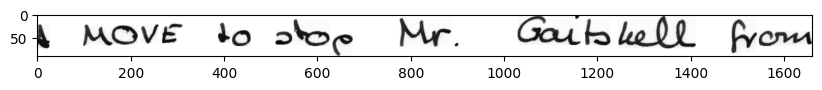

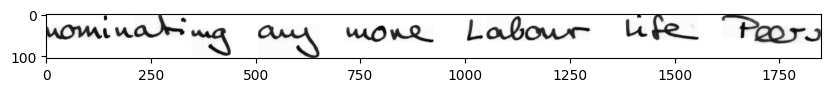

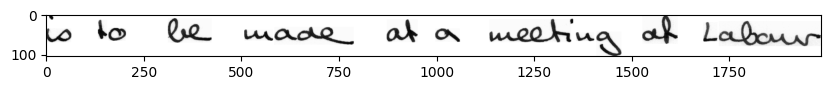

In [ ]:
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

In [ ]:
  encoder = LabelEncoder()
  encoder.fit(img_targets)
  encoded_Y = encoder.transform(img_targets)

  print(img_files[:5], img_targets[:5], encoded_Y[:5])

['/content/drive/MyDrive/data_subset/data_subset/a01-000u-s00-00.png'
 '/content/drive/MyDrive/data_subset/data_subset/a01-000u-s00-01.png'
 '/content/drive/MyDrive/data_subset/data_subset/a01-000u-s00-02.png'
 '/content/drive/MyDrive/data_subset/data_subset/a01-000u-s00-03.png'
 '/content/drive/MyDrive/data_subset/data_subset/a01-000u-s01-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


In [ ]:
train_files, rem_files, train_targets, rem_targets = train_test_split(img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3233,) (833,) (833,)
(3233,) (833,) (833,)


In [ ]:
# Generator function for generating random crops from each sentence

# # Now create generators for randomly cropping 113x113 patches from these images

batch_size = 16
num_classes = 50

# Start with train generator shared in the class and add image augmentations
def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train, y_train)

In [ ]:
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

In [ ]:
def resize_image(image):
  import tensorflow as tf
  return tf.image.resize(image, [56, 56])

# Function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
model.add(Lambda(resize_image))  #resize images to allow for easy computation

# CNN model - Building the model suggested in paper

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 115, 115, 1)      0         
 2D)                                                             
                                                                 
 lambda (Lambda)             (None, 56, 56, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 32)        832       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                                                        

In [ ]:
nb_epoch = 2

samples_per_epoch =3268
nb_val_samples =842


#save every model using Keras checkpoint
from keras.callbacks import ModelCheckpoint
path_to_drive = '/content/drive/MyDrive/'
filepath = path_to_drive + "checkpoint2/check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

#Model fit generator
history_object = model.fit(train_generator, steps_per_epoch=samples_per_epoch, validation_data=validation_generator, validation_steps=nb_val_samples, epochs=nb_epoch, verbose=1, callbacks=callbacks_list)


Epoch 1/8
 231/3268 [=>............................] - ETA: 13:05:34 - loss: 3.4071 - accuracy: 0.2118

In [ ]:
#model.load_weights('low_loss.hdf5')
scores = model.evaluate_generator(test_generator,60)
print("Accuracy = ", scores[1])

<ipython-input-13-f8c74c558456>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator,60)


Accuracy =  0.30794385075569153


In [ ]:
images = []
for filename in test_files[:50]:
     im = Image.open(filename)
     cur_width = im.size[0]
     cur_height = im.size[1]

     # print(cur_width, cur_height)
     height_fac = 113 / cur_height

     new_width = int(cur_width * height_fac)
     size = new_width, 113

     imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
     now_width = imresize.size[0]
     now_height = imresize.size[1]
     # Generate crops of size 113x113 from this resized image and keep random 10% of crops

     avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

     # Pick random x%
     factor = 0.1
     pick_num = int(len(avail_x_points)*factor)

     random_startx = sample(avail_x_points,  pick_num)

     for start in random_startx:
         imcrop = imresize.crop((start, 0, start+113, 113))
         images.append(np.asarray(imcrop))

     X_test = np.array(images)

     X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
     #convert to float and normalize
     X_test = X_test.astype('float32')
     X_test /= 255
     shuffle(X_test)
print(X_test.shape)

(6351, 113, 113, 1)


In [ ]:
predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
     predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))
print(predictions)

199/199 [==============================] - 1s 4ms/step
(6351, 50)
6351
[[1.9391809e-02 1.4687001e-02 2.1697821e-03 ... 2.2816071e-02
  1.5911717e-02 3.6595080e-02]
 [1.9391809e-02 1.4687001e-02 2.1697821e-03 ... 2.2816071e-02
  1.5911717e-02 3.6595080e-02]
 [1.8986493e-02 1.4514101e-02 2.1458201e-03 ... 2.2753835e-02
  1.5885796e-02 3.6410071e-02]
 ...
 [9.8764485e-01 7.4790600e-09 1.3871691e-07 ... 2.5426281e-05
  1.3072036e-09 1.5158161e-05]
 [2.1970838e-02 1.5950744e-03 4.1019835e-02 ... 8.9910636e-03
  1.3127203e-02 2.7972220e-03]
 [4.8046098e-03 4.8770555e-03 3.4040764e-02 ... 1.6002964e-02
  4.8338339e-02 5.6676129e-03]]


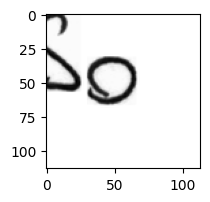

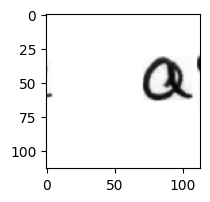

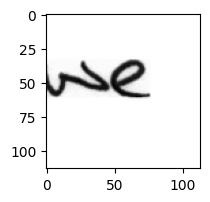

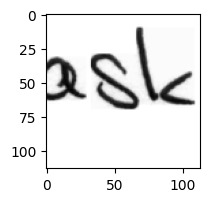

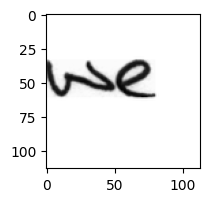

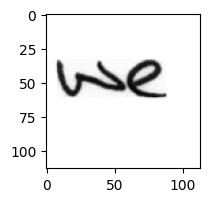

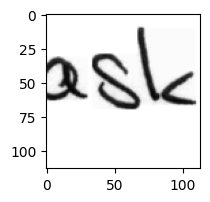

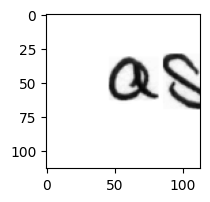

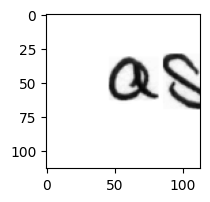

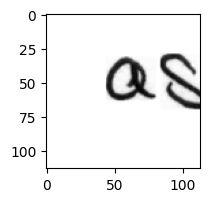

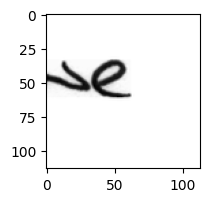

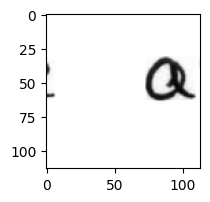

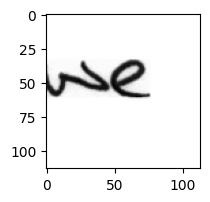

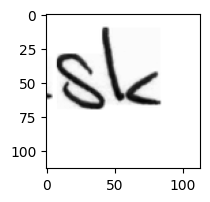

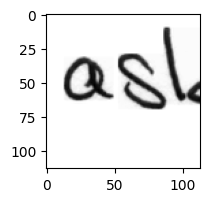

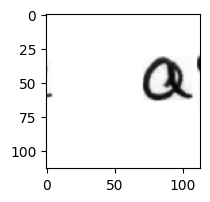

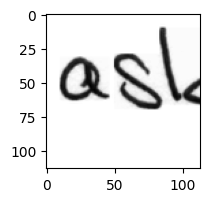

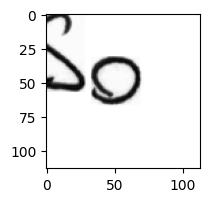

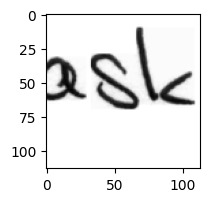

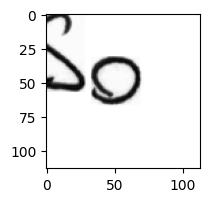

In [ ]:
writer_number = 18
total_images =10
counter = 0
for i in range(len(predicted_writer)//10):
     if predicted_writer[i] == writer_number:
        image = X_test[i].squeeze()
        plt.figure(figsize=(2,2))
        plt.imshow(image, cmap ='gray')

In [ ]:
model.save('/content/drive/MyDrive/model.h5')

In [ ]:
from PIL import Image
import numpy as np
from keras.models import load_model

# Load the trained model
model = load_model('/content/drive/MyDrive/model.h5')

# Preprocess your image data
image_path = '/content/a01-003u-s00-01.png'
image = Image.open(image_path)
image = image.resize((113, 113))  # Resize the image to 113x113
image = np.asarray(image)
image = image.reshape((1, 113, 113, 1))  # Reshape to match model input shape
image = image.astype('float32') / 255.0  # Normalize pixel values

# Make predictions
predictions = model.predict(image)
predicted_class = np.argmax(predictions)

print('Predicted class:', predicted_class)

1/1 [==============================] - 0s 109ms/step
Predicted class: 42


In [ ]:
image_path = '/content/a01-003u-s00-01.png'
image = Image.open(image_path)
text = pytesseract.image_to_string(image)
print(text)

SAppor* | ~ lasrac mealon by at LaWowsr

